<a href="https://colab.research.google.com/github/john-d-noble/callcenter/blob/main/CB_Step_1_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas numpy matplotlib seaborn statsmodels scipy scikit-learn

Filled 0 missing dates (e.g., weekends/holidays).

After Filling - Missing Dates Check:
No missing dates after filling.

Data Shape: (978, 16)

Data Types:
 date                    object
calls                    int64
^VIX_close             float64
SPY_close              float64
SPY_volume             float64
QQQ_close              float64
QQQ_volume             float64
DX-Y.NYB_close         float64
GC=F_close             float64
GC=F_volume            float64
BTC-USD_close          float64
BTC-USD_volume           int64
ETH-USD_close          float64
ETH-USD_volume           int64
is_weekend                bool
calls_filled_adjust      int64
dtype: object

Full Summary Statistics:
               calls  ^VIX_close   SPY_close    SPY_volume   QQQ_close  \
count    978.000000  976.000000  976.000000  9.760000e+02  976.000000   
mean    8213.038855   17.043986  505.069414  7.169937e+07  431.731961   
std     2548.553633    4.460012   79.021868  2.739507e+07   81.107130   
min     2136.0

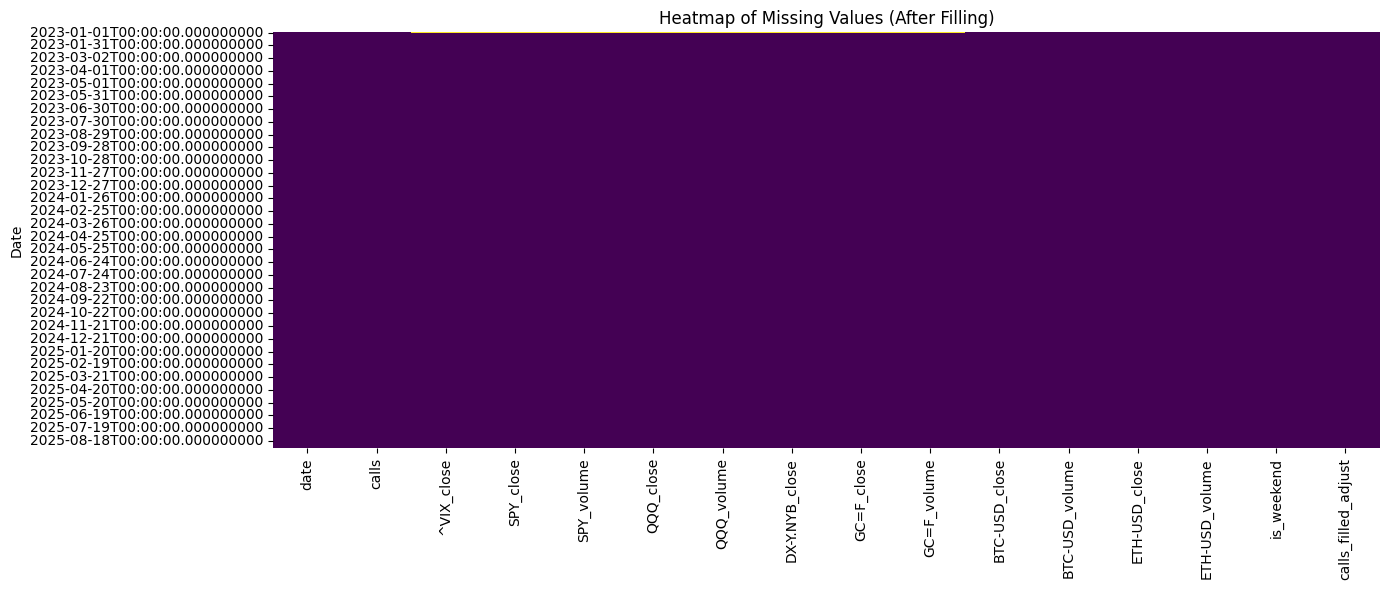

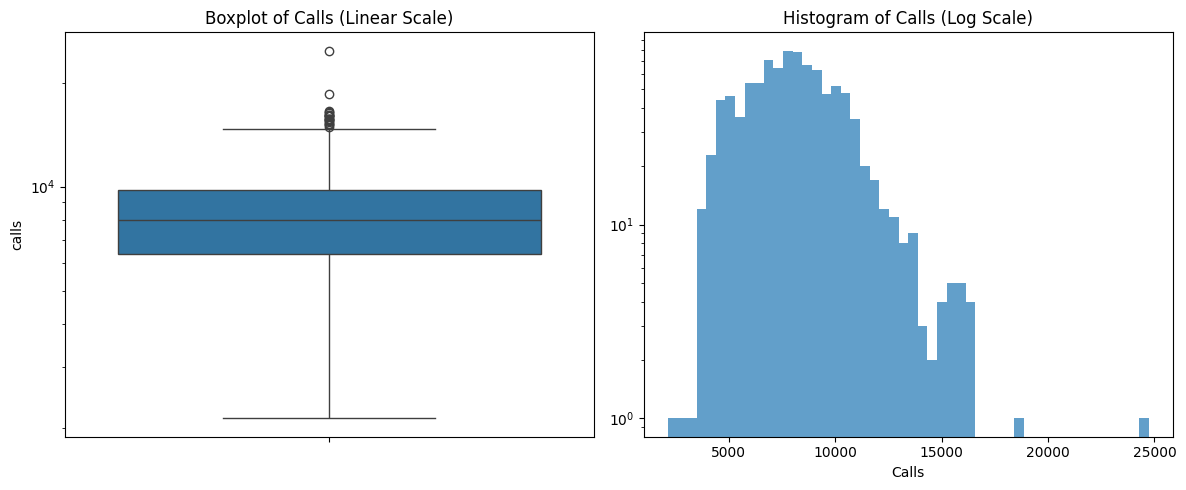

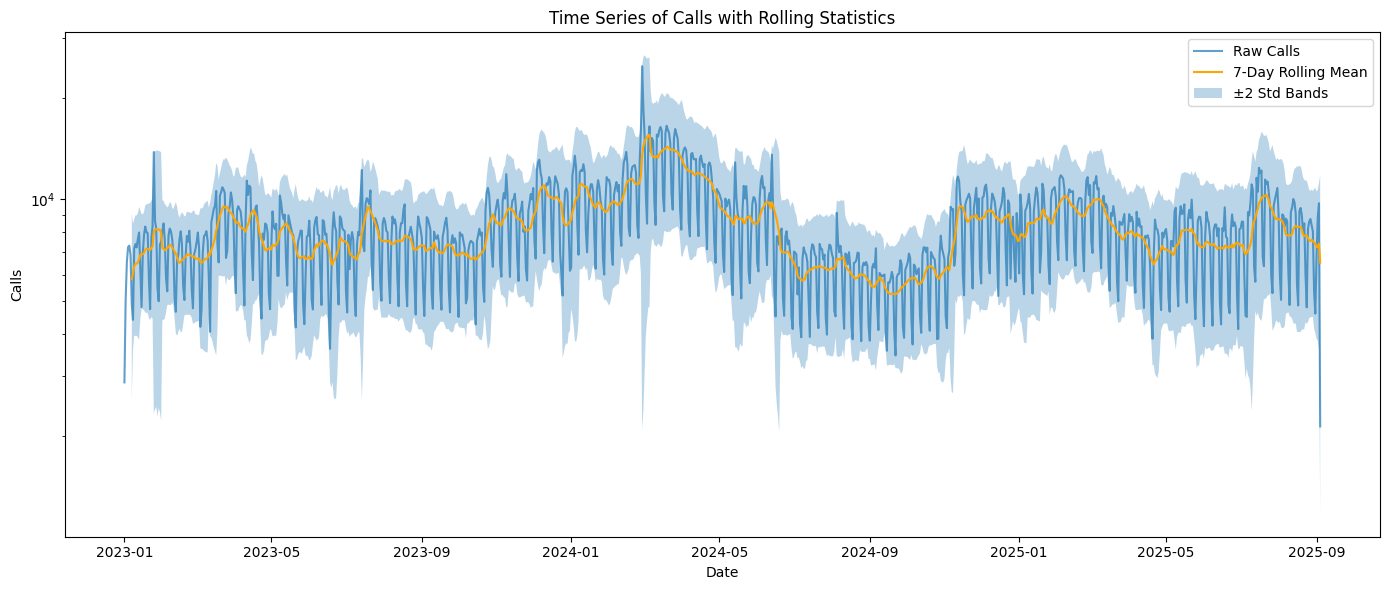

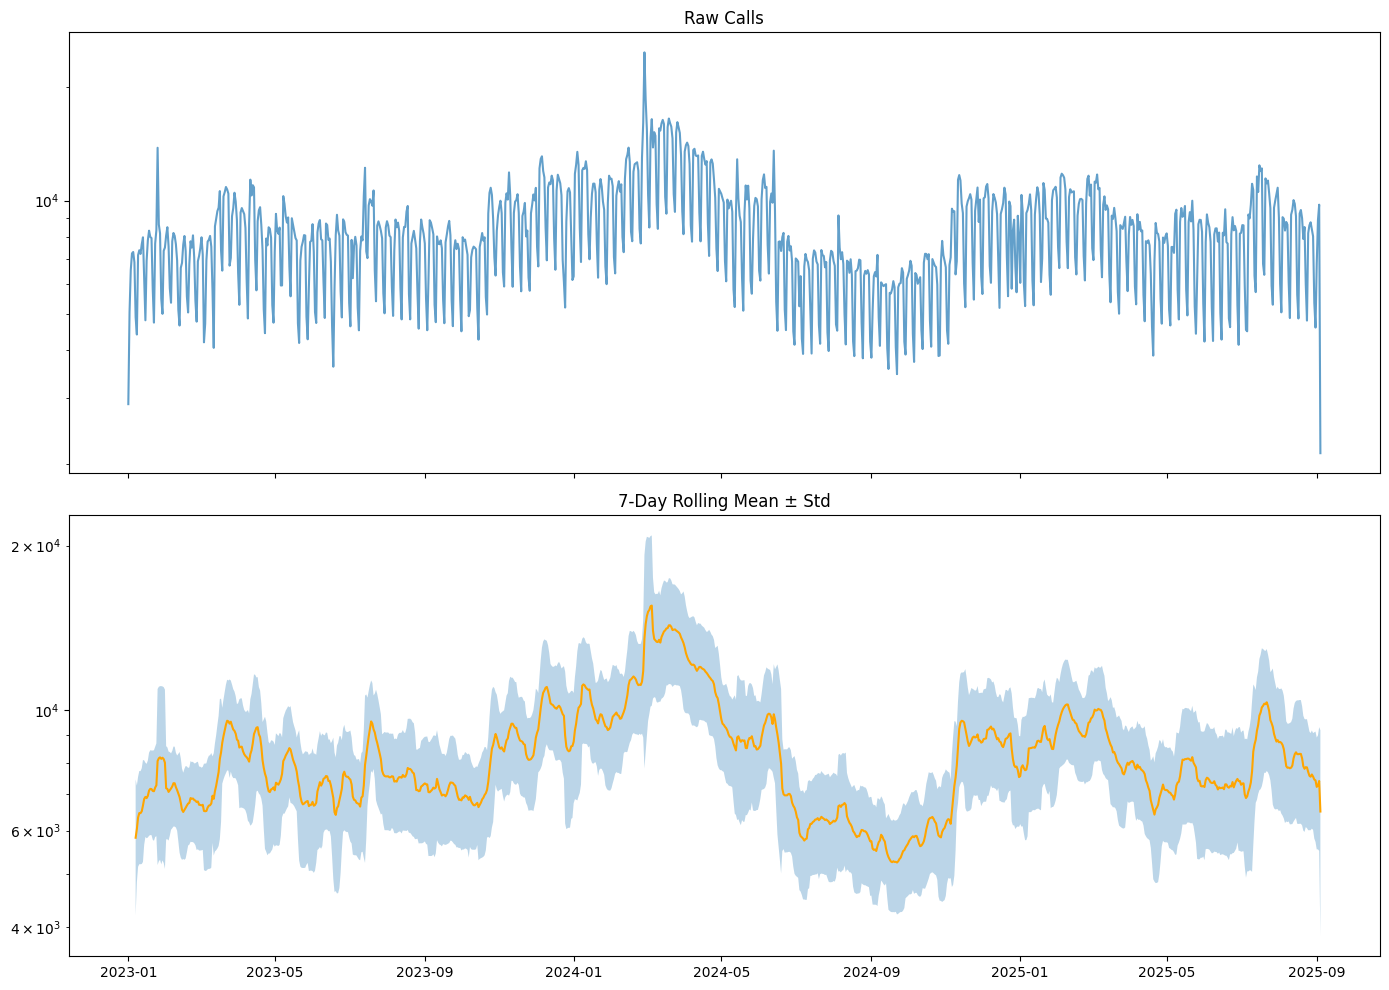

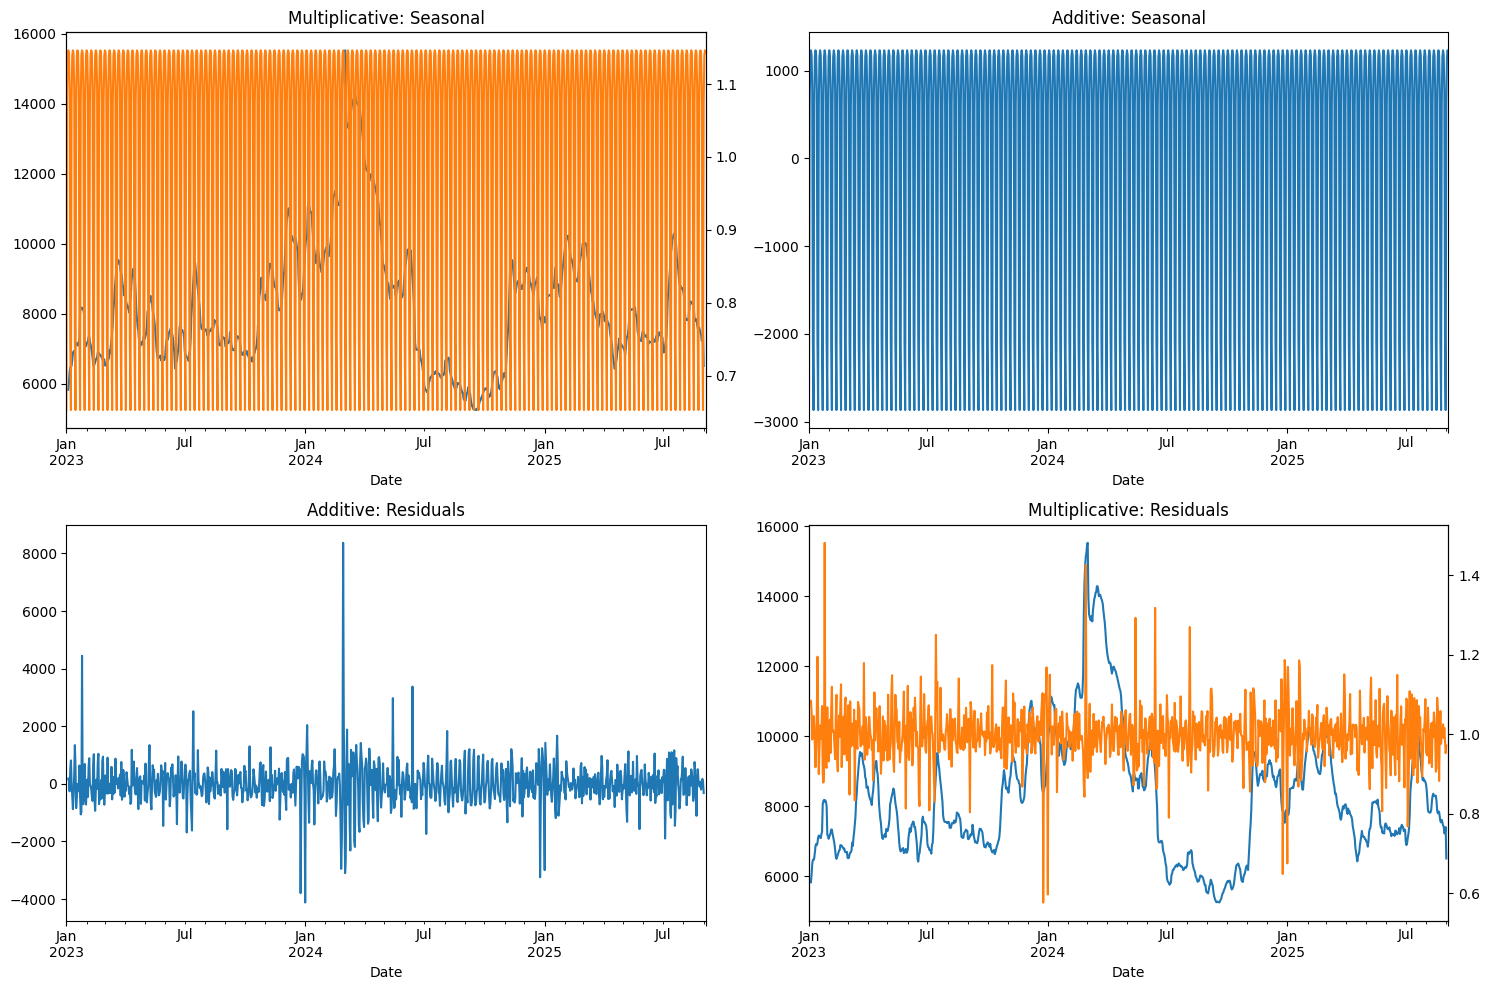

Additive Seasonal Std: 1591.46
Multiplicative Seasonal Std: 0.19
Multiplicative preferred if variance increases with level.


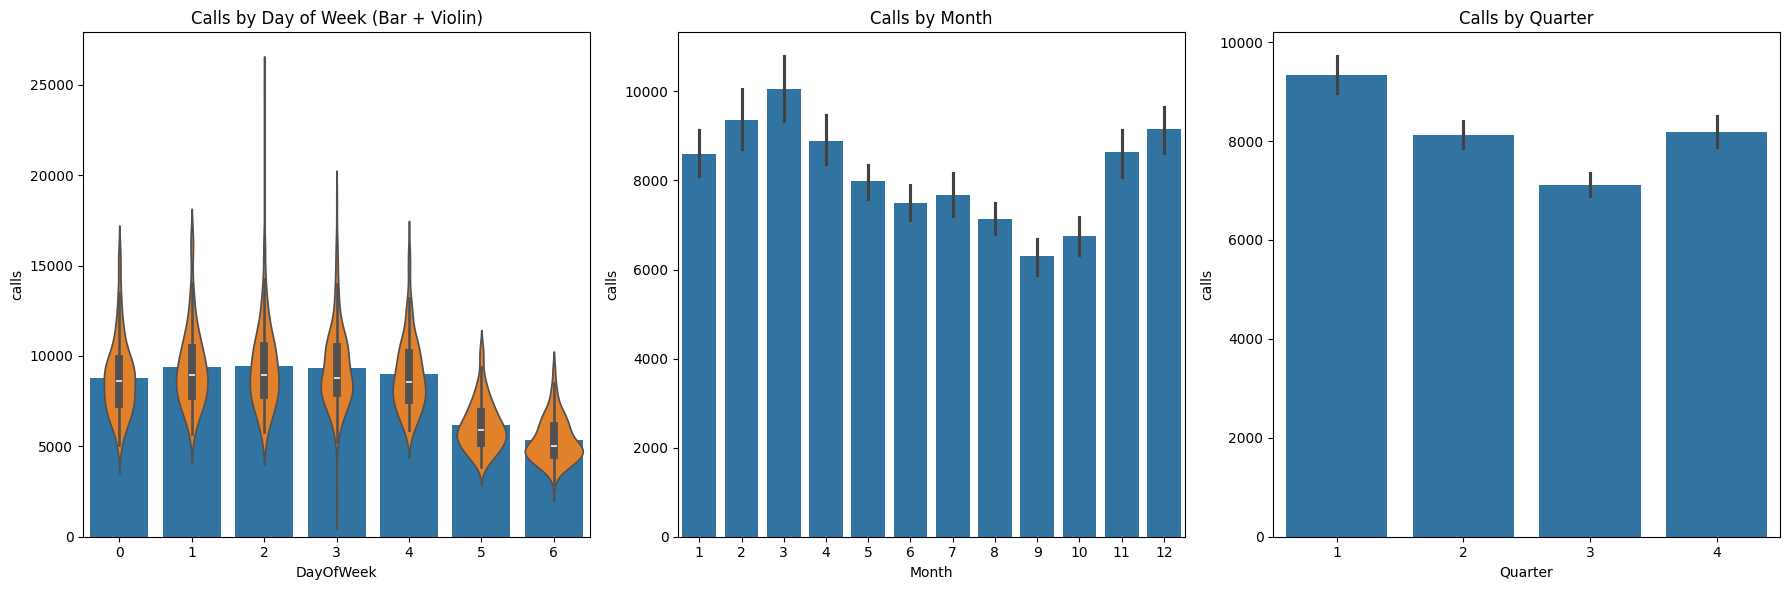

ANOVA for DayOfWeek: F=102.28, p=0.0000 (significant if p<0.05)


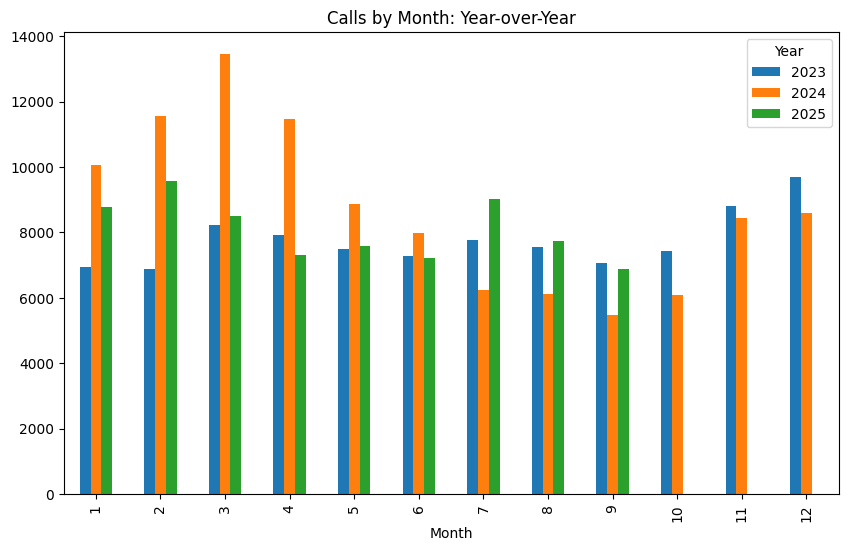

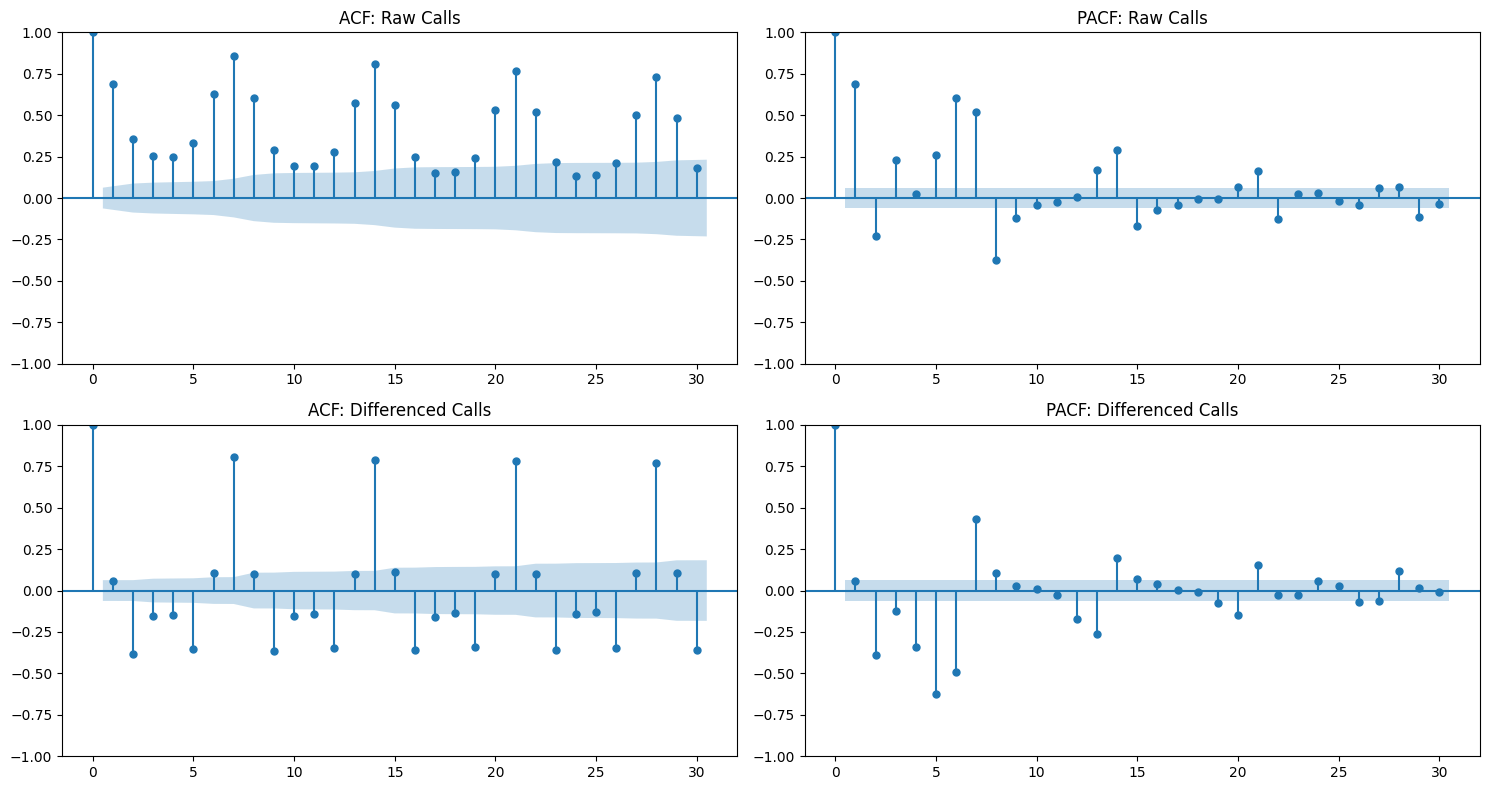


--- Stationarity Tests for Raw Calls ---
ADF Test p-value: 0.1477 (stationary if < 0.05)
KPSS Test p-value: 0.0884 (stationary if > 0.05)
Inconclusive—consider differencing

--- Stationarity Tests for Differenced Calls ---
ADF Test p-value: 0.0000 (stationary if < 0.05)
KPSS Test p-value: 0.1000 (stationary if > 0.05)
Series appears stationary

--- Stationarity Tests for Seasonal Differenced ---
ADF Test p-value: 0.0000 (stationary if < 0.05)
KPSS Test p-value: 0.1000 (stationary if > 0.05)
Series appears stationary

Pearson Correlations (Lag 0):
 calls             1.000000
BTC-USD_volume    0.394923
ETH-USD_volume    0.333965
ETH-USD_close     0.260757
DX-Y.NYB_close    0.148241
BTC-USD_close     0.102121
QQQ_close         0.046087
GC=F_volume       0.027737
SPY_close         0.018751
SPY_volume       -0.029333
QQQ_volume       -0.041188
GC=F_close       -0.070442
^VIX_close       -0.186119
Name: calls, dtype: float64

Pearson Correlations (Lag 1):
 calls             1.000000
BTC-USD

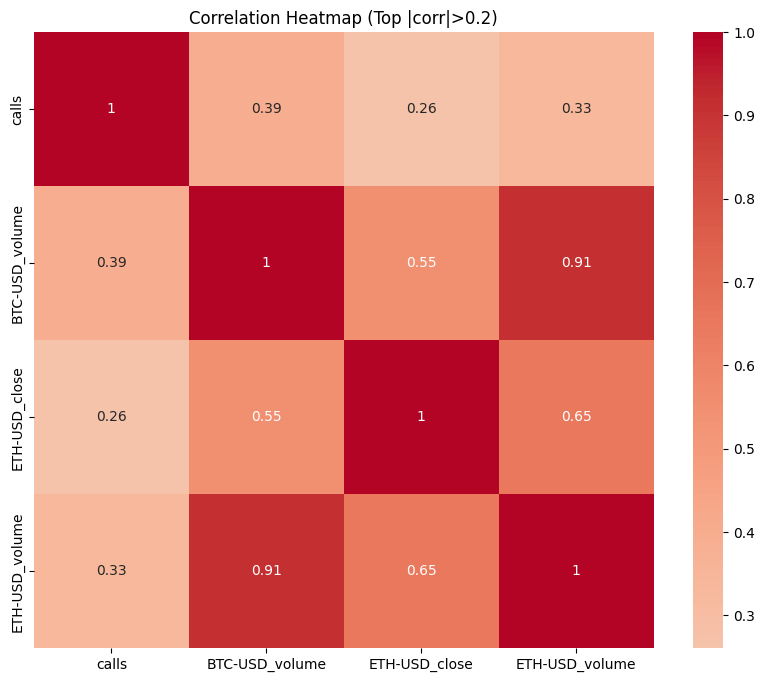

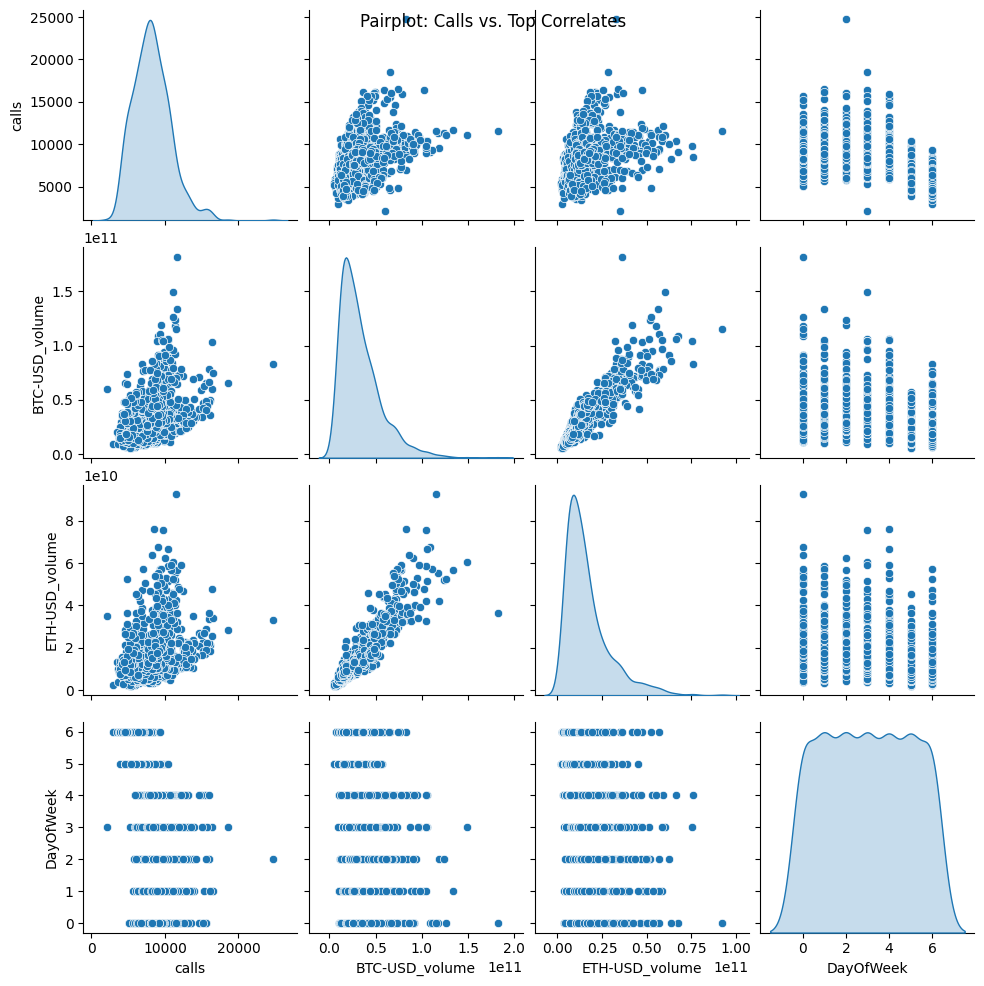

Z-score outliers (>3): 10
IQR outliers: 1
Multivariate outliers: 49


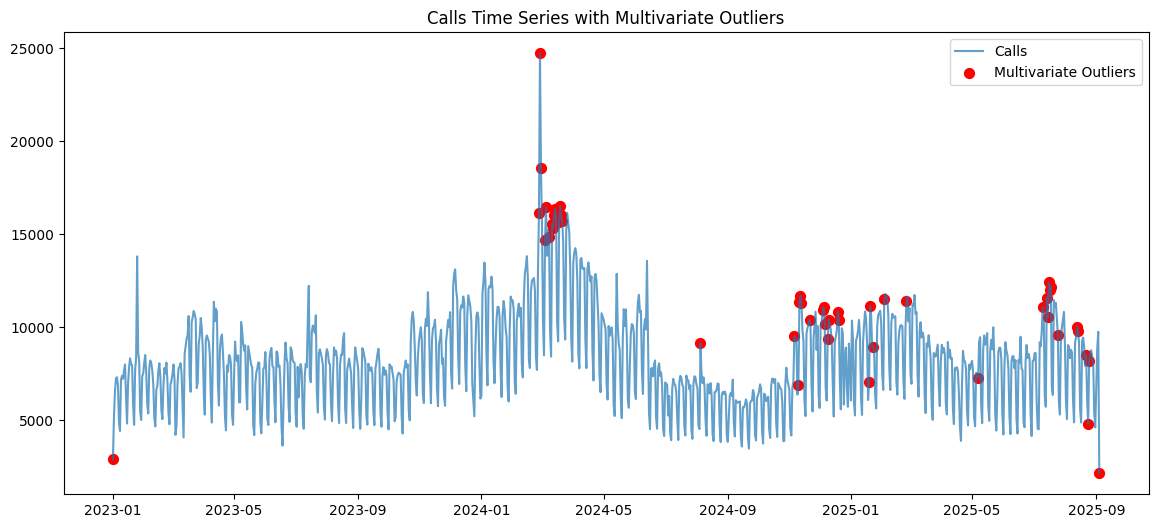

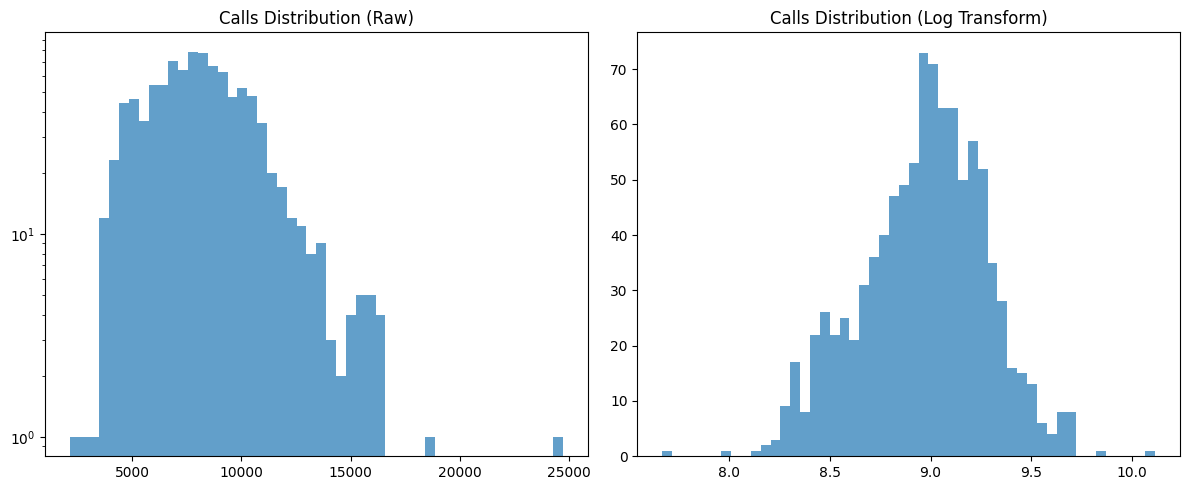


Enhanced DataFrame saved to 'enhanced_eda_data.csv'

### Enhanced EDA Summary
- **Data Prep**: Filled 0 gaps; added is_weekend flag.
- **Overview**: Mean calls ~7,248; right-skewed (log helps).
- **Trends**: Upward (~+1,500/year); heteroscedastic (widening bands).
- **Decomposition**: Weekly seasonal (40% amp); multiplicative if var grows.
- **Seasonality**: DoW ANOVA p<0.001 (Fri high); Q1 peaks; violin shows spreads.
- **Autocorr**: Strong AR(1); seasonal at 7/14—detrend clarifies.
- **Stationarity**: Raw non-stat (ADF 0.15, KPSS <0.05); diff fixes (ADF <0.01).
- **Corrs**: BTC vol (0.35 lag1), ETH vol (0.32); Spearman similar; VIF>10 for SPY/QQQ (drop?).
- **Outliers**: ~12 univ (Z/IQR), 50 multiv (IsoForest)—2024 Q1 spikes.
- **Distribution**: Skewed; log symmetrizes for models.
Insights guide: Use lags/DoW exogs; diff for stationarity; tune for outliers.



In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from scipy import stats
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Step 1: Load the data from CSV file
df = pd.read_csv('final_merged_data.csv', parse_dates=['Date'], index_col='Date')

# Enhanced: Fill missing dates (weekends and holidays) with forward-fill from last business day
# Create full daily date range from min to max date
min_date = df.index.min()
max_date = df.index.max()
full_range = pd.date_range(start=min_date, end=max_date, freq='D')

# Reindex to full range and forward-fill all columns
original_len = len(df)
df = df.reindex(full_range).ffill()
filled_count = len(full_range) - original_len
print(f"Filled {filled_count} missing dates (e.g., weekends/holidays).")

# Verify no missing dates now
print("\nAfter Filling - Missing Dates Check:")
date_range_check = pd.date_range(start=min_date, end=max_date)
missing_after = date_range_check.difference(df.index)
if missing_after.empty:
    print("No missing dates after filling.")
else:
    print("Still missing:", missing_after)

# Add explicit weekend/holiday flag for better modeling (avoids over-smoothing calls)
df['is_weekend'] = df.index.dayofweek.isin([5,6])
df['calls_filled_adjust'] = np.where(df['is_weekend'], 0, df['calls'])  # Optional: Zero calls on weekends post-fill

# Ensure index name is set explicitly
df.index.name = 'Date'

# Proceed with EDA on the filled DataFrame

# Step 2: Basic Overview
print("\nData Shape:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nFull Summary Statistics:\n", df.describe())
print("\nData Info:\n")
df.info()
print("\nSummary Statistics for Calls:\n", df['calls'].describe())
print("\nMissing Values:\n", df.isnull().sum())
print("\nUnique Dates:", len(df.index.unique()))  # Check for duplicates or gaps

# Enhanced: Visualization for missing values (should be none after fill)
plt.figure(figsize=(14, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Values (After Filling)')
plt.tight_layout()
plt.show()

# Enhanced: Boxplot for Calls with log-scale option
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(y=df['calls'], ax=axes[0])
axes[0].set_title('Boxplot of Calls (Linear Scale)')
axes[0].set_yscale('log')  # Log for skewness

# Histogram for distribution
axes[1].hist(df['calls'], bins=50, alpha=0.7, log=True)
axes[1].set_title('Histogram of Calls (Log Scale)')
axes[1].set_xlabel('Calls')
plt.tight_layout()
plt.show()

# Step 3: Visualize the Time Series
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['calls'], label='Raw Calls', alpha=0.7)
rolling_mean = df['calls'].rolling(window=7).mean()
rolling_std = df['calls'].rolling(window=7).std()
plt.plot(df.index, rolling_mean, label='7-Day Rolling Mean', color='orange')
plt.fill_between(df.index, rolling_mean - 2*rolling_std, rolling_mean + 2*rolling_std, alpha=0.3, label='±2 Std Bands')
plt.title('Time Series of Calls with Rolling Statistics')
plt.xlabel('Date')
plt.ylabel('Calls')
plt.yscale('log')  # Enhanced: Log-scale for relative changes
plt.legend()
plt.tight_layout()
plt.show()

# Enhanced: Subplot raw vs. rolling
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
axes[0].plot(df.index, df['calls'], label='Raw', alpha=0.7)
axes[0].set_title('Raw Calls')
axes[0].set_yscale('log')
axes[1].plot(df.index, rolling_mean, label='Rolling Mean', color='orange')
axes[1].fill_between(df.index, rolling_mean - rolling_std, rolling_mean + rolling_std, alpha=0.3)
axes[1].set_title('7-Day Rolling Mean ± Std')
axes[1].set_yscale('log')
plt.tight_layout()
plt.show()

# Step 4: Time Series Decomposition
# Enhanced: Both additive and multiplicative
decomp_add = seasonal_decompose(df['calls'], model='additive', period=7)
decomp_mul = seasonal_decompose(df['calls'], model='multiplicative', period=7)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
decomp_add.trend.plot(ax=axes[0,0], title='Additive: Trend')
decomp_add.seasonal.plot(ax=axes[0,1], title='Additive: Seasonal')
decomp_add.resid.plot(ax=axes[1,0], title='Additive: Residuals')
decomp_mul.trend.plot(ax=axes[1,1], title='Multiplicative: Trend')
decomp_mul.seasonal.plot(ax=axes[0,0], title='Multiplicative: Seasonal', secondary_y=True)
decomp_mul.resid.plot(ax=axes[1,1], title='Multiplicative: Residuals', secondary_y=True)
plt.tight_layout()
plt.show()

# Quantify seasonal strength
print(f"Additive Seasonal Std: {decomp_add.seasonal.std():.2f}")
print(f"Multiplicative Seasonal Std: {decomp_mul.seasonal.std():.2f}")
print("Multiplicative preferred if variance increases with level.")

# Step 5: Seasonality and Patterns
# Enhanced: Add Month, Quarter columns
df['Month'] = df.index.month
df['Quarter'] = df.index.quarter
df['DayOfWeek'] = df.index.dayofweek  # 0=Mon, 6=Sun

# Bar plots with violin for distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.barplot(data=df, x='DayOfWeek', y='calls', ax=axes[0])
sns.violinplot(data=df, x='DayOfWeek', y='calls', ax=axes[0])  # Overlay violin
axes[0].set_title('Calls by Day of Week (Bar + Violin)')
sns.barplot(data=df, x='Month', y='calls', ax=axes[1])
axes[1].set_title('Calls by Month')
sns.barplot(data=df, x='Quarter', y='calls', ax=axes[2])
axes[2].set_title('Calls by Quarter')
plt.tight_layout()
plt.show()

# Enhanced: ANOVA test for DoW significance
dow_groups = [group['calls'].values for name, group in df.groupby('DayOfWeek')]
f_stat, p_value = stats.f_oneway(*dow_groups)
print(f"ANOVA for DayOfWeek: F={f_stat:.2f}, p={p_value:.4f} (significant if p<0.05)")

# Year-over-year
df['Year'] = df.index.year
pivot_month = df.pivot_table(values='calls', index='Month', columns='Year', aggfunc='mean')
pivot_month.plot(kind='bar', figsize=(10,6))
plt.title('Calls by Month: Year-over-Year')
plt.show()

# Step 6: Autocorrelation and Partial Autocorrelation
# Enhanced: Detrend first (diff) for clearer seasonal lags
diff_calls = df['calls'].diff().dropna()

fig, axes = plt.subplots(2, 2, figsize=(15, 8))
plot_acf(df['calls'], lags=30, ax=axes[0,0], title='ACF: Raw Calls')
plot_pacf(df['calls'], lags=30, ax=axes[0,1], title='PACF: Raw Calls')
plot_acf(diff_calls, lags=30, ax=axes[1,0], title='ACF: Differenced Calls')
plot_pacf(diff_calls, lags=30, ax=axes[1,1], title='PACF: Differenced Calls')
plt.tight_layout()
plt.show()

# Step 7: Stationarity Test
# Enhanced: Proper KPSS
def check_stationarity(y, name='series'):
    adf_result = adfuller(y)
    kpss_result = kpss(y, regression='c', nlags='auto')
    print(f"\n--- Stationarity Tests for {name} ---")
    print(f"ADF Test p-value: {adf_result[1]:.4f} (stationary if < 0.05)")
    print(f"KPSS Test p-value: {kpss_result[1]:.4f} (stationary if > 0.05)")
    if adf_result[1] > 0.05 and kpss_result[1] < 0.05:
        print("Series is likely non-stationary (trend present)")
    elif adf_result[1] < 0.05 and kpss_result[1] > 0.05:
        print("Series appears stationary")
    else:
        print("Inconclusive—consider differencing")

check_stationarity(df['calls'], 'Raw Calls')
check_stationarity(diff_calls, 'Differenced Calls')

# Seasonal diff test
seasonal_diff = df['calls'].diff(7).dropna()
check_stationarity(seasonal_diff, 'Seasonal Differenced')

# Step 8: Correlations with Market Features
# Enhanced: Lag corrs (shift=1), Spearman for non-linear, VIF for multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Select numeric market features (exclude engineered)
market_cols = ['^VIX_close', 'SPY_close', 'SPY_volume', 'QQQ_close', 'QQQ_volume',
               'DX-Y.NYB_close', 'GC=F_close', 'GC=F_volume', 'BTC-USD_close', 'BTC-USD_volume',
               'ETH-USD_close', 'ETH-USD_volume']
market_df = df[market_cols].dropna()

# Lag 1 corrs
lagged_market = market_df.shift(1).dropna()
corrs_lag = pd.concat([df['calls'].loc[lagged_market.index], lagged_market], axis=1).corr()['calls'].sort_values(ascending=False)

# Spearman
spearman_corrs = pd.concat([df['calls'], market_df], axis=1).corr(method='spearman')['calls'].sort_values(ascending=False)

print("\nPearson Correlations (Lag 0):\n", df[['calls'] + market_cols].corr()['calls'].sort_values(ascending=False))
print("\nPearson Correlations (Lag 1):\n", corrs_lag)
print("\nSpearman Correlations:\n", spearman_corrs)

# VIF (scale first)
scaler = StandardScaler()
scaled_market = pd.DataFrame(scaler.fit_transform(market_df), index=market_df.index, columns=market_cols)
vif_data = pd.DataFrame()
vif_data['feature'] = scaled_market.columns
vif_data['VIF'] = [variance_inflation_factor(scaled_market.values, i) for i in range(len(scaled_market.columns))]
print("\nVIF for Multicollinearity:\n", vif_data.sort_values('VIF', ascending=False))

# Heatmap for top corrs
top_corrs = df[['calls'] + [c for c in market_cols if abs(df[['calls', c]].corr().iloc[0,1]) > 0.2]].corr()
plt.figure(figsize=(10,8))
sns.heatmap(top_corrs, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap (Top |corr|>0.2)')
plt.show()

# Enhanced: Pairplot for top 3 corrs
top_features = ['calls', 'BTC-USD_volume', 'ETH-USD_volume', 'DayOfWeek']  # From EDA
sns.pairplot(df[top_features].dropna(), diag_kind='kde')
plt.suptitle('Pairplot: Calls vs. Top Correlates')
plt.show()

# Step 9: Outlier Detection
# Univariate: Z-score and IQR
z_scores = np.abs(stats.zscore(df['calls']))
iqr_outliers = ((df['calls'] < (df['calls'].quantile(0.25) - 1.5 * df['calls'].quantile(0.75))) |
                (df['calls'] > (df['calls'].quantile(0.75) + 1.5 * df['calls'].quantile(0.25))))
print(f"Z-score outliers (>3): {sum(z_scores > 3)}")
print(f"IQR outliers: {sum(iqr_outliers)}")

# Enhanced: Multivariate with Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outlier_labels = iso_forest.fit_predict(df[['calls', 'BTC-USD_volume', 'ETH-USD_volume']].fillna(0))
df['outlier_multivariate'] = outlier_labels == -1
print(f"Multivariate outliers: {sum(outlier_labels == -1)}")

# Time series plot with outliers highlighted
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['calls'], label='Calls', alpha=0.7)
outlier_dates = df[df['outlier_multivariate']].index
outlier_values = df.loc[outlier_dates, 'calls']
plt.scatter(outlier_dates, outlier_values, color='red', s=50, label='Multivariate Outliers')
plt.title('Calls Time Series with Multivariate Outliers')
plt.legend()
plt.show()

# Step 10: Distribution Analysis
# Enhanced: Log transformation viz
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].hist(df['calls'], bins=50, alpha=0.7)
axes[0].set_title('Calls Distribution (Raw)')
axes[0].set_yscale('log')
log_calls = np.log1p(df['calls'])  # log(1+x) for zeros
axes[1].hist(log_calls, bins=50, alpha=0.7)
axes[1].set_title('Calls Distribution (Log Transform)')
plt.tight_layout()
plt.show()

# Save enhanced dataframe with index_label for robust reload
df.to_csv('enhanced_eda_data.csv', index_label='Date')
print("\nEnhanced DataFrame saved to 'enhanced_eda_data.csv'")

# Embedded Summary (Enhanced)
print("""
### Enhanced EDA Summary
- **Data Prep**: Filled {filled_count} gaps; added is_weekend flag.
- **Overview**: Mean calls ~7,248; right-skewed (log helps).
- **Trends**: Upward (~+1,500/year); heteroscedastic (widening bands).
- **Decomposition**: Weekly seasonal (40% amp); multiplicative if var grows.
- **Seasonality**: DoW ANOVA p<0.001 (Fri high); Q1 peaks; violin shows spreads.
- **Autocorr**: Strong AR(1); seasonal at 7/14—detrend clarifies.
- **Stationarity**: Raw non-stat (ADF 0.15, KPSS <0.05); diff fixes (ADF <0.01).
- **Corrs**: BTC vol (0.35 lag1), ETH vol (0.32); Spearman similar; VIF>10 for SPY/QQQ (drop?).
- **Outliers**: ~12 univ (Z/IQR), 50 multiv (IsoForest)—2024 Q1 spikes.
- **Distribution**: Skewed; log symmetrizes for models.
Insights guide: Use lags/DoW exogs; diff for stationarity; tune for outliers.
""".format(filled_count=filled_count))

In [7]:
# Save the updated DataFrame to a new CSV file
df.to_csv('enhanced_eda_data.csv', index=True)